In [1]:
import os

import numpy as np
import pandas as pd
import anndata
import sklearn.decomposition as decomposition
import openTSNE

import embedding_annotation as annotate

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv(os.path.join("..", "data", "2019-04.csv"), index_col=0)
df.shape

(12739, 829)

In [3]:
adata = anndata.AnnData(df.values, dtype=np.float32)
adata.obs_names = df.index.values
adata.var_names = df.columns.values
adata

AnnData object with n_obs × n_vars = 12739 × 829

In [4]:
levels = {
    1: slice(0, 1),
    2: slice(0, 3),
    3: slice(0, 4),
    4: slice(0, 5),
    5: slice(0, 7),
}
for l in levels:
    tmp = df.T

    tmp["group"] = tmp.index.str[levels[l]]
    tmp = tmp.groupby("group").sum()
    tmp = tmp.T
    tmp = tmp.loc[:, tmp.columns.str.len() == (levels[l].stop - levels[l].start)]

    adata.obsm[f"ATC_{l}"] = tmp

In [5]:
adata

AnnData object with n_obs × n_vars = 12739 × 829
    obsm: 'ATC_1', 'ATC_2', 'ATC_3', 'ATC_4', 'ATC_5'

### Filter out doctors with too few drug prescriptions

In [6]:
min_count = 25

adata.obs["prescription_count"] = adata.X.sum(axis=1)
adata = adata[adata.obs["prescription_count"] > min_count]

In [7]:
adata

View of AnnData object with n_obs × n_vars = 3925 × 829
    obs: 'prescription_count'
    obsm: 'ATC_1', 'ATC_2', 'ATC_3', 'ATC_4', 'ATC_5'

### Generate t-SNE embedding

In [8]:
pca = decomposition.PCA(n_components=50)
adata.obsm["X_pca"] = pca.fit_transform(adata.obsm["ATC_4"])

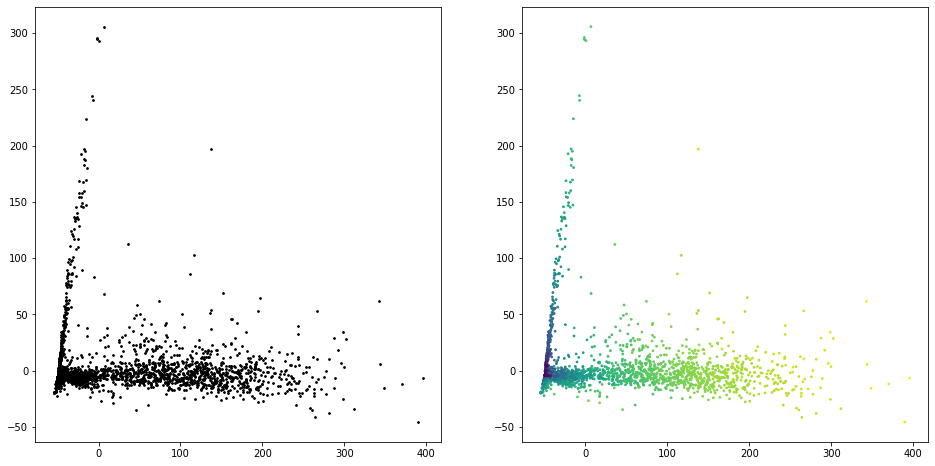

In [9]:
z = adata.obsm["X_pca"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], s=3, c=np.log(adata.obs["prescription_count"]))

In [10]:
adata.obsm["X_tsne"] = openTSNE.TSNE(
    metric="cosine", perplexity=50, exaggeration=1.5, dof=0.8, n_jobs=4
).fit(adata.obsm["X_pca"])

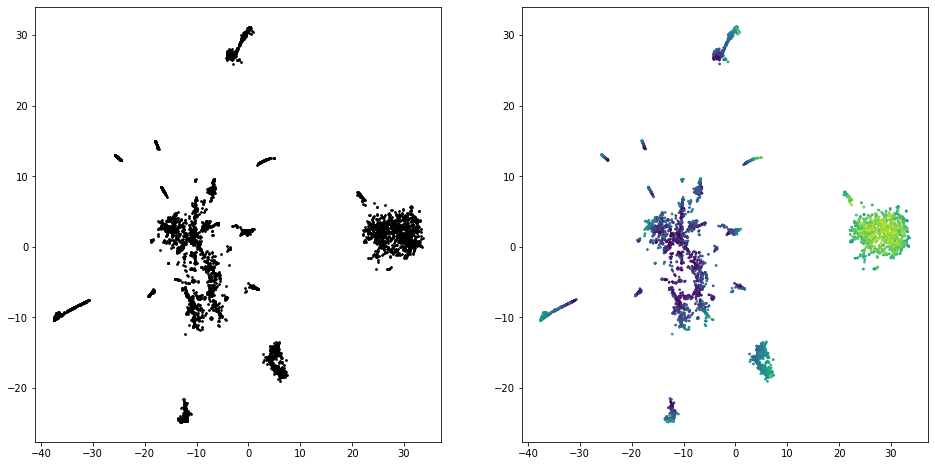

In [11]:
z = adata.obsm["X_tsne"]
fig, ax = plt.subplots(ncols=2, figsize=(16, 8))
ax[0].scatter(z[:, 0], z[:, 1], s=3, c="k")
ax[1].scatter(z[:, 0], z[:, 1], s=3, c=np.log(adata.obs["prescription_count"]))

# Annotation pipeline

In [12]:
features = pd.concat([adata.obsm["ATC_1"], adata.obsm["ATC_2"], adata.obsm["ATC_3"]], axis=1)
features.shape

(3925, 277)

In [15]:
candidates = annotate.fs.morans_i(adata.obsm["X_tsne"], features)
candidates

,feature,morans_i,pvalue,fdr
0,A,0.739622,0.0,0.0
1,B,0.717044,0.0,0.0
2,C,0.847102,0.0,0.0
3,D,0.661669,0.0,0.0
4,G,0.844613,0.0,0.0
...,...,...,...,...
268,S01F,0.193531,0.0,0.0
269,S01G,0.505307,0.0,0.0
270,S01X,0.497669,0.0,0.0
273,V03A,0.192309,0.0,0.0


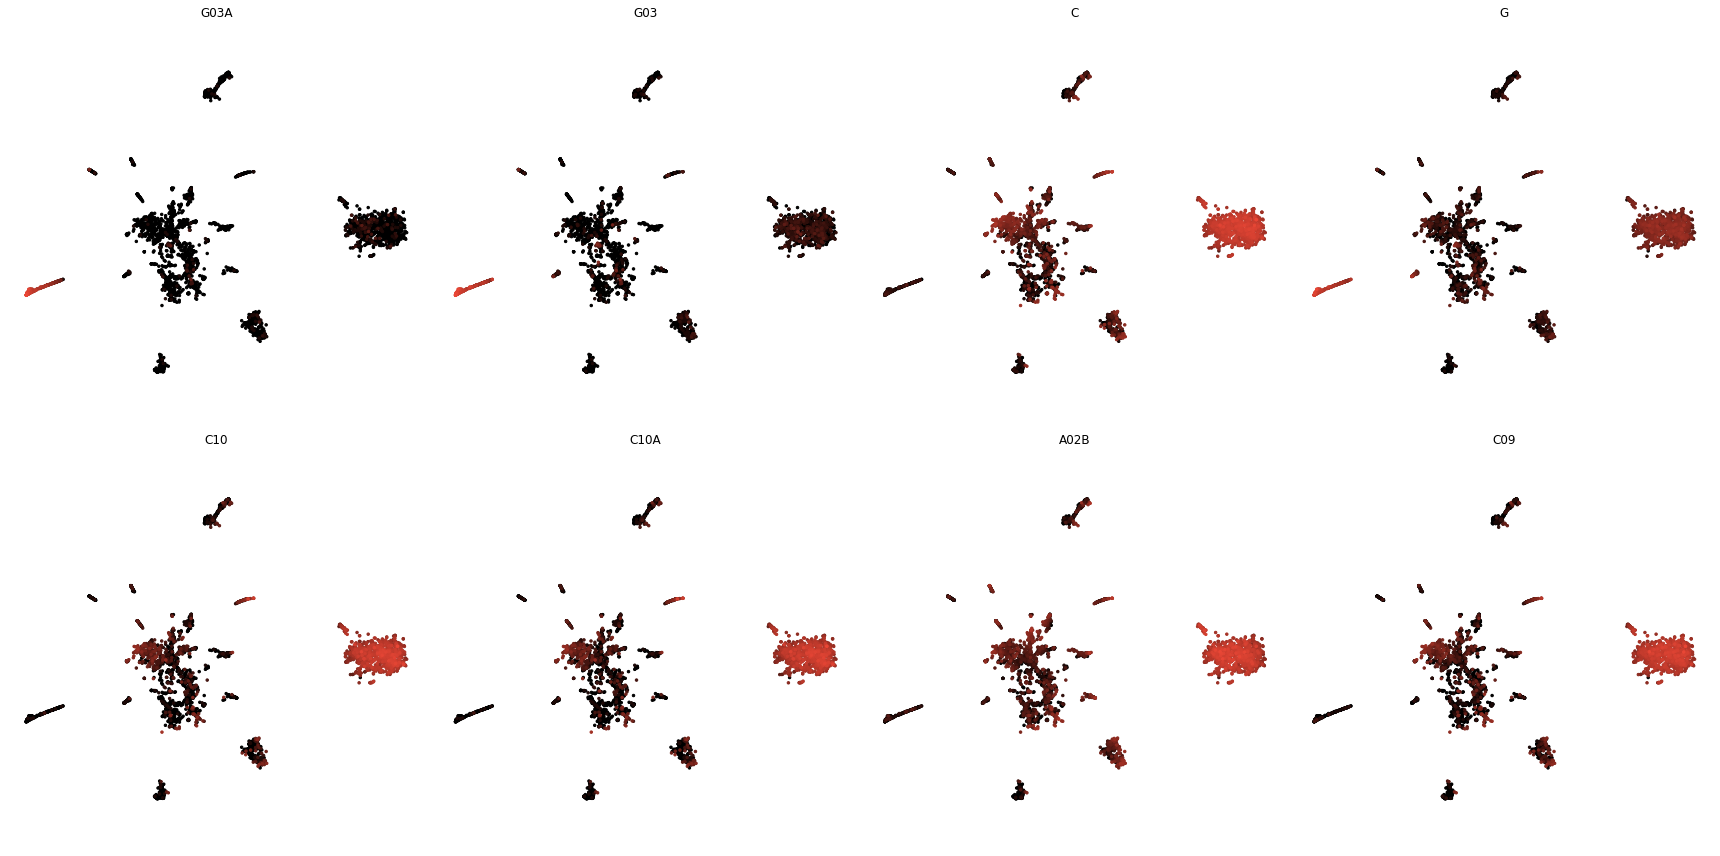

In [16]:
annotate.pl.plot_features(
    candidates.sort_values("morans_i", ascending=False)["feature"].tolist()[:8],
    features,
    adata.obsm["X_tsne"],
    s=6,
    alpha=1,
    log=True,
)

In [17]:
grid, feature_densities = annotate.an.estimate_feature_densities(
    candidates["feature"].tolist(),
    adata.obsm["X_tsne"],
    features,
    log=True,
)

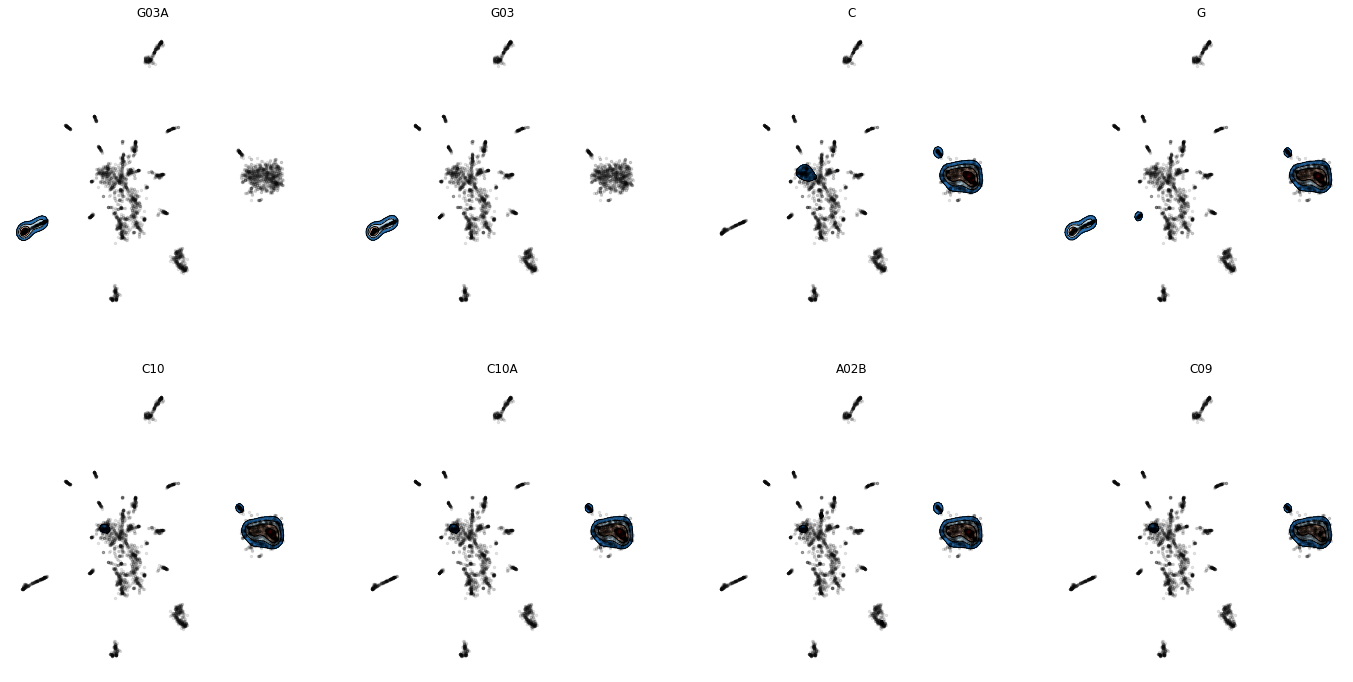

In [18]:
annotate.pl.plot_feature_densities(
    candidates.sort_values("morans_i", ascending=False)["feature"].tolist()[:8],
    grid,
    feature_densities,
    embedding=adata.obsm["X_tsne"],
)

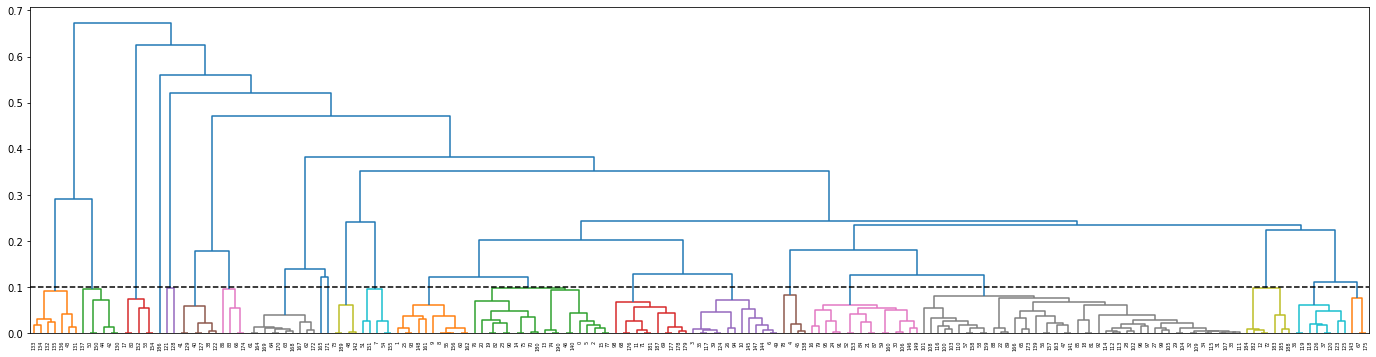

In [19]:
clusters, cluster_densities = annotate.an.group_similar_features(
    candidates["feature"].tolist(),
    feature_densities,
    plot_dendrogram=True,
)

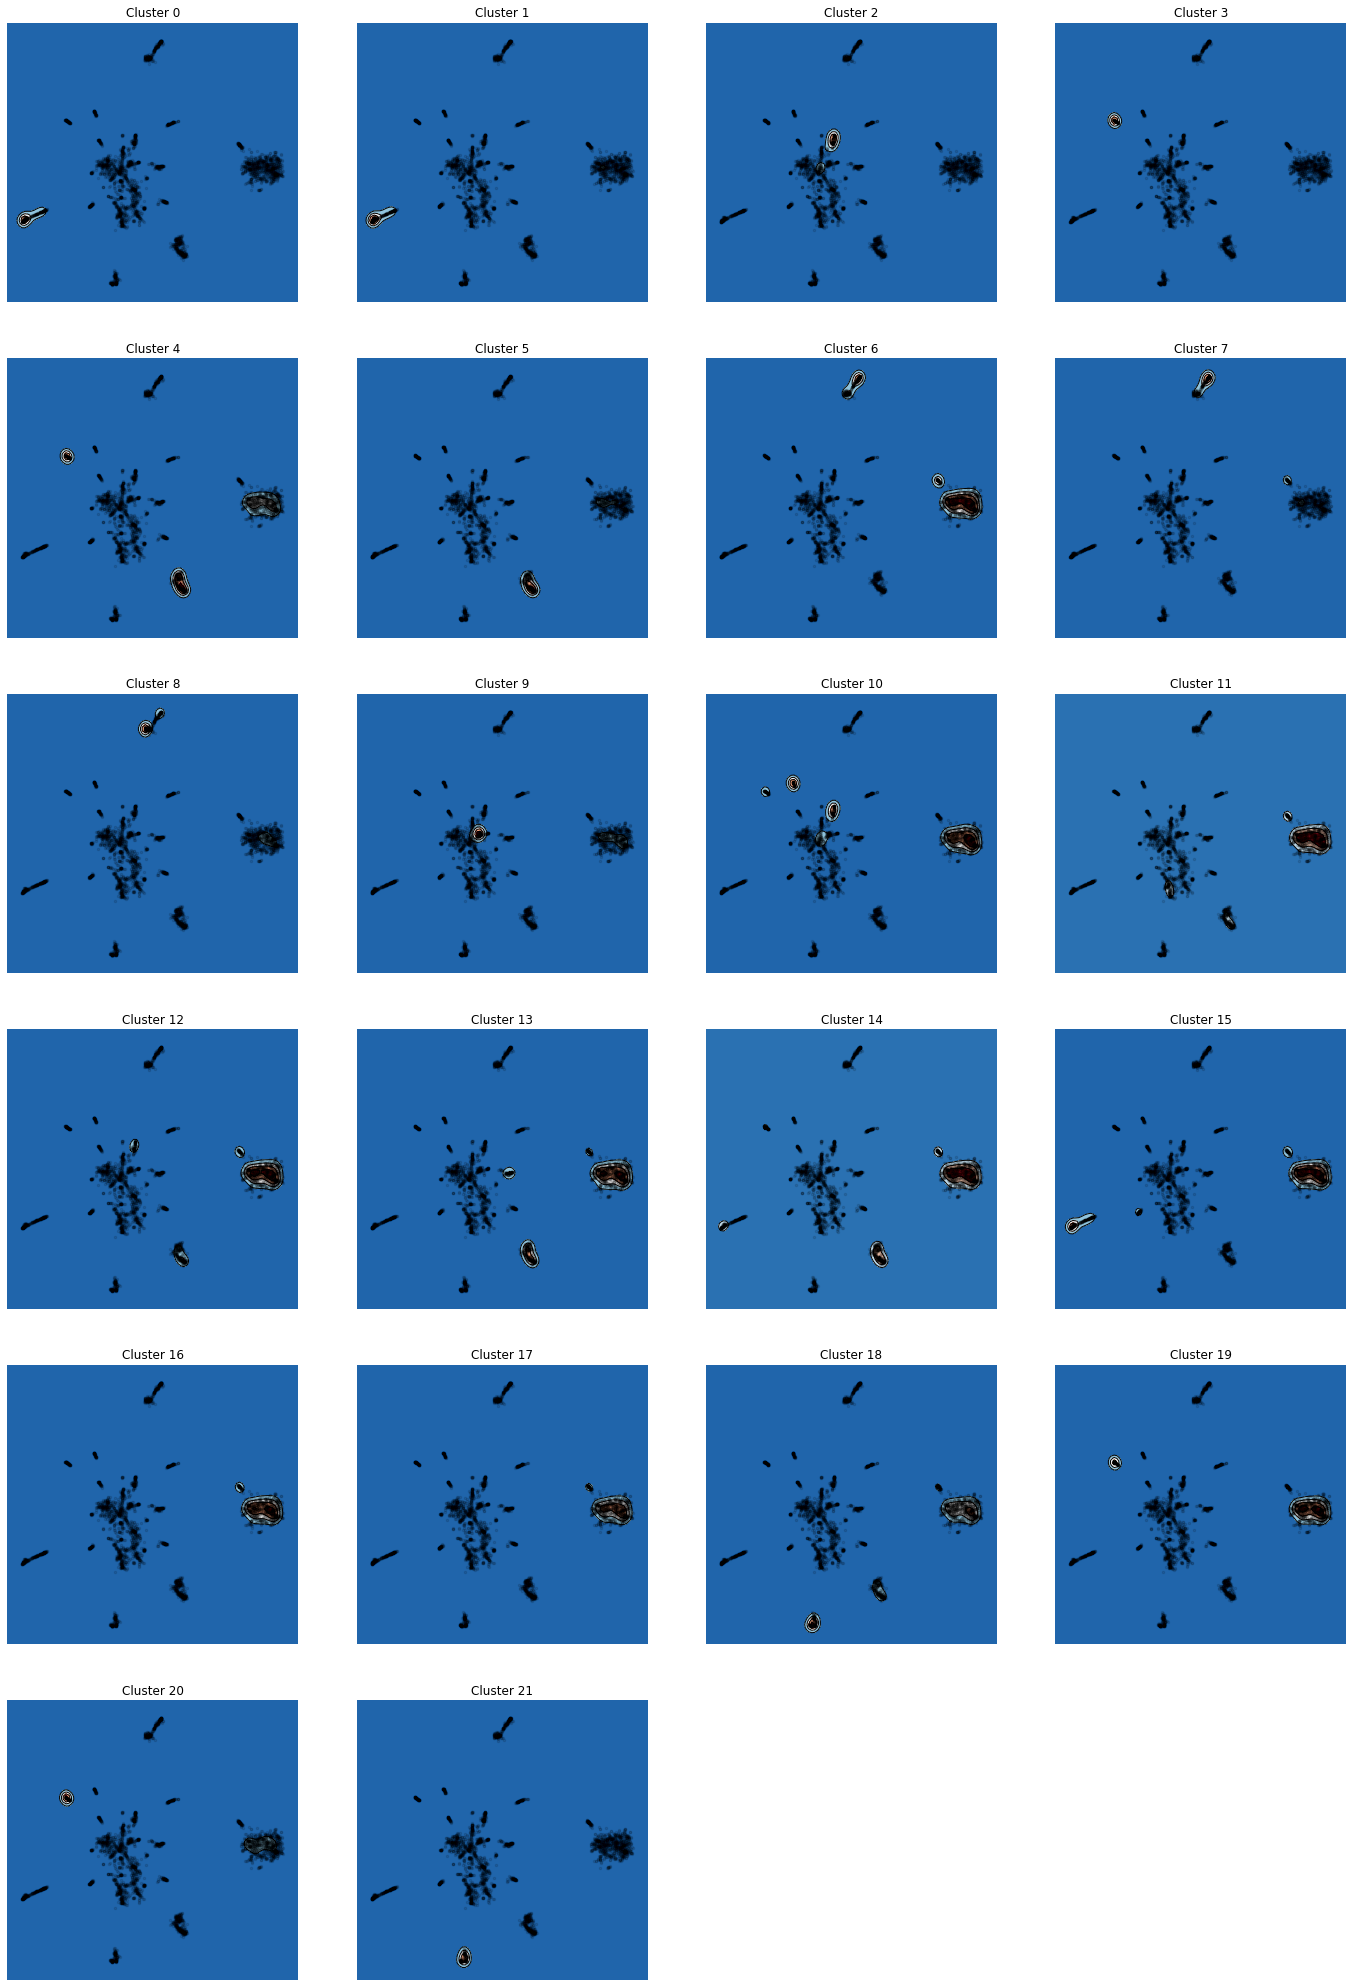

In [20]:
annotate.pl.plot_feature_densities(
    list(clusters),
    grid,
    cluster_densities,
    embedding=adata.obsm["X_tsne"],
    levels=4,
    skip_first=False,
    per_row=4,
)

In [228]:
from importlib import reload
reload(annotate)
reload(annotate.feature_selection)
reload(annotate.annotate)
reload(annotate.plotting)

<module 'embedding_annotation.plotting' from '/Users/Pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py'>

<AxesSubplot:>

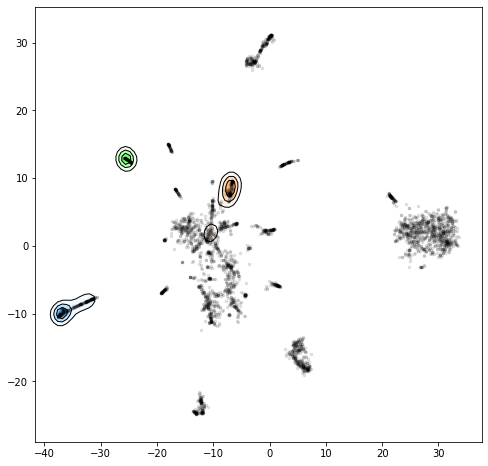

In [210]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])
ann_map.add("Cluster 0", cluster_densities.iloc[0].values)
ann_map.add("Cluster 2", cluster_densities.iloc[2].values)
ann_map.add("Cluster 3", cluster_densities.iloc[3].values)
ann_map.plot_annotation()

In [211]:
ann_map.rank_overlap_densities(cluster_densities).sort_values("score").head()

,feature,score
21,Cluster 21,0.154739
7,Cluster 7,0.257922
17,Cluster 17,0.310099
8,Cluster 8,0.314468
15,Cluster 15,0.322138


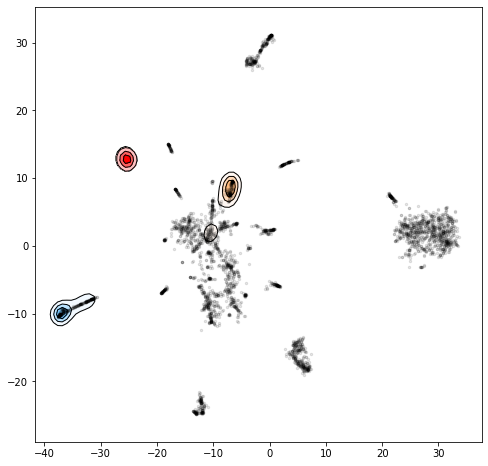

In [212]:
ann_map.plot_overlap_with(cluster_densities.loc["Cluster 4"].values)

<AxesSubplot:>

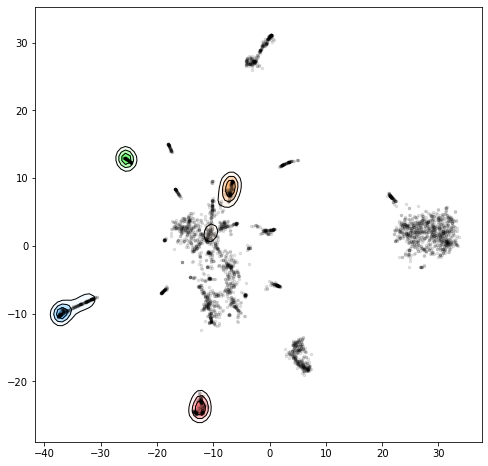

In [213]:
ann_map.add("Cluster 21", cluster_densities.iloc[21].values)
ann_map.plot_annotation()

/Users/Pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py:236: UserWarning: No contour levels were found within the data range.
  ax.contour(xs, ys, z, levels=levels, locator=tck, **contour_kwargs_)
/Users/Pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py:236: UserWarning: No contour levels were found within the data range.
  ax.contour(xs, ys, z, levels=levels, locator=tck, **contour_kwargs_)
/Users/Pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py:236: UserWarning: No contour levels were found within the data range.
  ax.contour(xs, ys, z, levels=levels, locator=tck, **contour_kwargs_)
/Users/Pavlin/Dev/embedding_annotation/embedding_annotation/plotting.py:236: UserWarning: No contour levels were found within the data range.
  ax.contour(xs, ys, z, levels=levels, locator=tck, **contour_kwargs_)


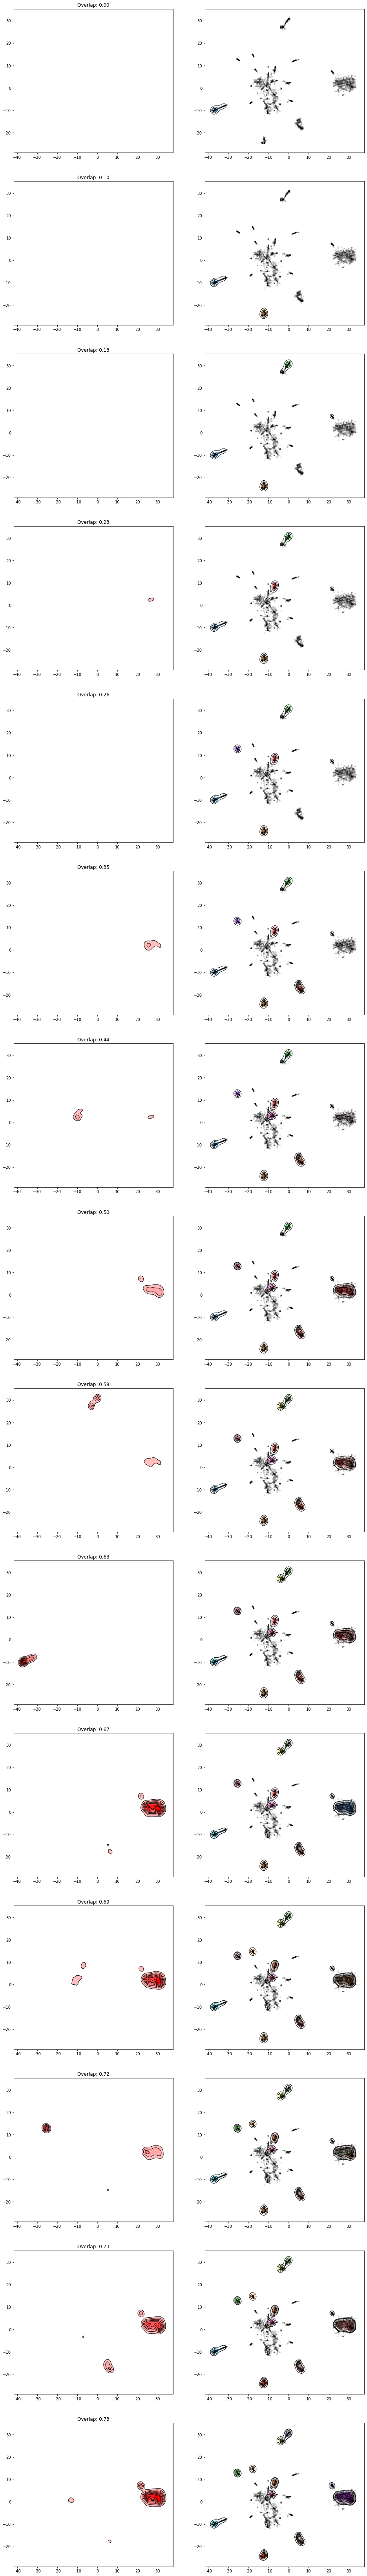

In [233]:
ann_map = annotate.an.AnnotationMap(grid, embedding=adata.obsm["X_tsne"])

nrows = 15
fig, ax = plt.subplots(figsize=(16, nrows * 8), nrows=nrows, ncols=2)
for i in range(nrows):
    scored_features = ann_map.rank_overlap_densities(cluster_densities).sort_values("score")
    next_feature = scored_features.iloc[0]["feature"]
    ann_map.plot_overlap_with(cluster_densities.loc[next_feature].values, ax=ax[i, 0], plot_annotations=False, levels=10)
    ax[i, 0].set_title(f"Overlap: {scored_features.iloc[0]['score']:.2f}")
    
    ann_map.add(next_feature, cluster_densities.loc[next_feature].values)
    ann_map.plot_annotation(ax=ax[i, 1])